In [10]:
import numpy as np
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))

df_wine.head()

C:\Users\nsats\Anaconda3\envs\gpu-env\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\nsats\Anaconda3\envs\gpu-env\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Class labels [1 2 3]


Class label  Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium  \
0            1    14.23        1.71  2.43               15.6        127   
1            1    13.20        1.78  2.14               11.2        100   
2            1    13.16        2.36  2.67               18.6        101   
3            1    14.37        1.95  2.50               16.8        113   
4            1    13.24        2.59  2.87               21.0        118   

   Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   Color intensity   Hue  OD280/OD315 of diluted wines  Proline  
0             5.64  1.04                          3.92     1065  
1             4.38  1.05                          3.40     1050  
2             5.68  1.03                          3.17     1185  
3             7.80  0.86                          3.45     1480  
4             4.32  1.04                          2.93      735

In [20]:
from sklearn.model_selection import train_test_split
X=df_wine.iloc[:,1:]
y=df_wine.iloc[:,0]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
X_train_std=ss.fit_transform(X_train)
X_test_std=ss.fit_transform(X_test)

In [35]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class SBS:
    def __init__(self,estimator,k_features,scoring=accuracy_score,test_size=0.25,random_state=1):
        self.scoring=scoring
        self.estimator=clone(estimator)
        self.k_features=k_features
        self.test_size=test_size
        self.random_state=random_state
        
    def fit(self,X,y):
        X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=self.test_size,random_state=self.random_state)
        # 特徴量の数dim
        dim=X_train.shape[1]
        self.indices_=tuple(range(dim))
        self.subsets_=[self.indices_]
        #　全特徴量でスコアを求める
        score=self._calc_score(X_train,y_train,X_test,y_test,self.indices_)
        self.scores_=[score]
        # 指定した特徴量になるまで特徴量を削減する
        while dim>self.k_features:
            scores=[]
            subsets=[]
            
            for p in combinations(self.indices_,r=dim-1):
                score=self._calc_score(X_train,y_train,X_test,y_test,p)
                scores.append(score)
                subsets.append(p)
         # scoreが最もよかった組み合わせのインデックスを取得       
            best=np.argmax(scores)
        # socreが最もよかった特徴量を取得
            self.indices_=subsets[best]
            self.subsets_.append(self.indices_)
        # 一つ次元を削減
            dim-=1
            
            self.scores_.append(scores[best])
        self.k_score_=self.scores_[-1]
        
        return self
    
    def transform(self,X):
        # 最後に残った特徴量を返す
        return X[:,self.indices_]
        
    def _calc_score(self,X_train,y_train,X_test,y_test,indices):
        self.estimator.fit(X_train[:,indices],y_train)
        y_pred=self.estimator.predict(X_test[:,indices])
        score=accuracy_score(y_test,y_pred)
        return score

In [36]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
%matplotlib inline
knn=KNeighborsClassifier(n_neighbors=2)
sbs=SBS(knn,k_features=1)
sbs.fit(X_train_std,y_train)

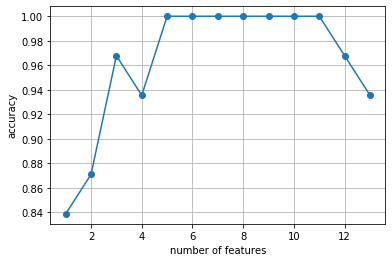

In [37]:
k_feat=[len(k) for k in sbs.subsets_]
plt.plot(k_feat,sbs.scores_,marker='o')
plt.ylabel('accuracy')
plt.xlabel('number of features')
plt.grid()
plt.show()

In [38]:
k5=list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


In [39]:
knn.fit(X_train_std,y_train)
print('train acc:',knn.score(X_train_std,y_train))
print('test acc:',knn.score(X_test_std,y_test))

knn.fit(X_train_std[:,k5],y_train)
print('train acc:',knn.score(X_train_std[:,k5],y_train))
print('test acc:',knn.score(X_test_std[:,k5],y_test))


train acc: 0.9838709677419355
test acc: 0.9444444444444444
train acc: 0.9596774193548387
test acc: 0.9259259259259259
